# Problem Set 7: Facial Recognition
<span style="color:red">WARNING:</span> Some of the problems in this problem set require heavy computation - you are encouraged to start early so that you don't get stuck at the last minute.

# Face Recognition

Your goal for this problem set is to design a basic face recognition system. Since the machine learning force is now strong with you, the prompts for this problem set are deliberately vague. Be creative - but be careful!

One suggestion: Start by implementing this entire problem set on a relatively small subset of all of the images first, before using the full dataset.

## 1. Data Exploration

Download the "[Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)" data set from [this link](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (roughly 250MB).

### 1.1. Filter out people with few images

Display a histogram that shows the number of images per individual (you may use log-scale if you like). Which individual has the most images? Throw away all people for whom you have fewer than 10 images.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage
from skimage import data
from skimage import io
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Getting Names
directory = './lfw_funneled'
names = [item for item in os.listdir(directory)]

# Getting the number of images of each person 
n_images = np.zeros(len(names))
for i in range(len(names)):
    req_dir = directory + '/' + names[i]
    n_images[i] = len([name for name in os.listdir(req_dir)])
    
n_images_df = pd.DataFrame({'Name':names, 'ImageCount':n_images})
n_images_df.sort_values('ImageCount',ascending=False)

Name  ImageCount
1870       George_W_Bush       530.0
1047        Colin_Powell       236.0
5458          Tony_Blair       144.0
1393     Donald_Rumsfeld       121.0
1891   Gerhard_Schroeder       109.0
...                  ...         ...
2231         Ira_Einhorn         1.0
2230          Iran_Brown         1.0
2229          Ion_Tiriac         1.0
2228         Ion_Iliescu         1.0
5748  Zydrunas_Ilgauskas         1.0

[5749 rows x 2 columns]

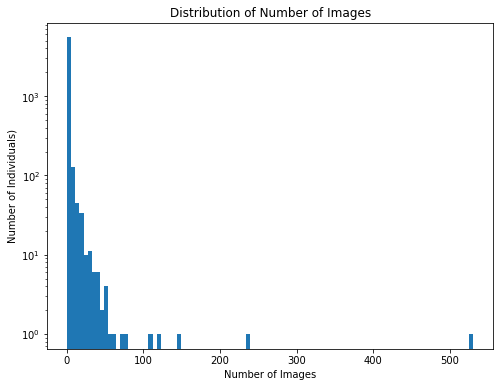

In [3]:
#Histogram of Number of Images
plt.figure(figsize=(8, 6))
plt.hist(n_images_df['ImageCount'], bins=100, log=True)
plt.title("Distribution of Number of Images")
plt.ylabel("Number of Individuals)")
plt.xlabel("Number of Images");

In [4]:
# Filtering the list of names for which there are fewer than 10 images
req_images_df = n_images_df[n_images_df['ImageCount'] >= 10]
req_images_df.reset_index(drop=True,inplace=True)
req_images_df

Name  ImageCount
0        Abdullah_Gul        19.0
1        Adrien_Brody        12.0
2    Alejandro_Toledo        39.0
3        Alvaro_Uribe        35.0
4     Amelie_Mauresmo        21.0
..                ...         ...
153    Vladimir_Putin        49.0
154    Walter_Mondale        10.0
155        Wen_Jiabao        13.0
156      Winona_Ryder        24.0
157  Yoriko_Kawaguchi        14.0

[158 rows x 2 columns]

- George_W_Bush has the most number of images (530 in number)

### 1.2. Show some faces!

1. Pick 8 random images from the dataset and display them in a 2 x 4 grid.
2. Create a single image that shows the "average face" (acros the entire dataset, not just the 8 random ones) -- i.e., each pixel should display the average value of that pixel across all of the images. 
3. For each pixel, calculate the standard deviation of values for that pixel (you will have a different standard deviation for each of the three color channels, feel free to just show the standard deviation of one of the channels, or to average the standard deviation of the three channels at each pixel). Plot these standard deviations as a heatmap.

What do you notice about the distribution of mean and standard deviation values in these images? (e.g., are they evenly distributed)

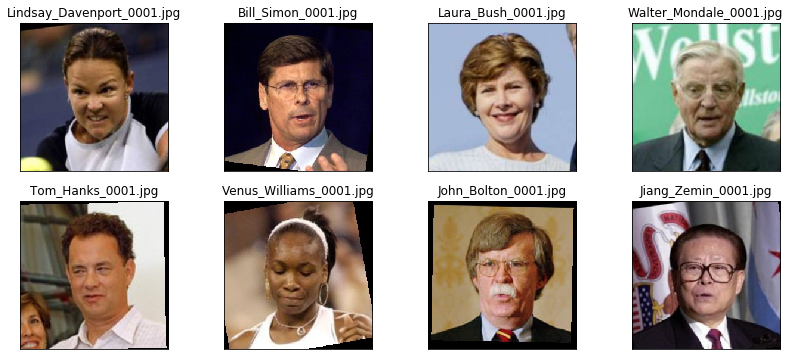

In [5]:
# 1. Displaying 8 random people
random_names= np.random.choice(req_images_df['Name'], 8)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(14,6))

ax = ax.flatten()

for i in range(len(random_names)):
    img = io.imread(directory+'/'+random_names[i]+'/'+random_names[i]+'_0001.jpg')
    ax[i].imshow(img)
    ax[i].set_title(random_names[i]+'_0001.jpg')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show()

In [6]:
#Reading all Images 
image_data = []
for i in range(len(req_images_df['Name'])):
    person=req_images_df['Name'][i]
    req_dir = directory + '/' + person
    imageList = [name for name in os.listdir(req_dir)]
    for image_name in imageList:
        image_data.append(io.imread(os.path.join(req_dir, image_name)))

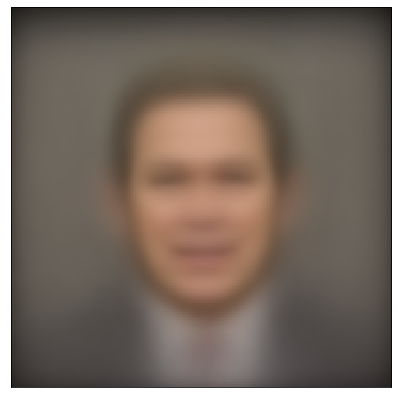

In [7]:
# 2. Average Face 
avg_face = np.mean(image_data,axis=0)
avg_face = avg_face/255

# Plot
fig, ax = plt.subplots(figsize=(7,7))

ax.imshow(avg_face)
ax.set_xticks([])
ax.set_yticks([])

plt.show(fig)

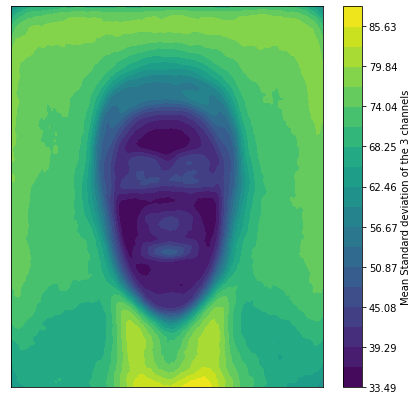

In [8]:
# 3. Standard Deviation of the Pixel

avg_face_std = np.std(image_data, axis=0).mean(axis=2)

fig, ax = plt.subplots(figsize=(7,7))

levels = np.linspace(np.min(avg_face_std),np.max(avg_face_std), 20)
cntrf = ax.contourf(np.arange(np.shape(avg_face_std)[0]),
                    np.arange(np.shape(avg_face_std)[1]),
                    avg_face_std,
                    cmap='viridis', levels=levels)
cbar = fig.colorbar(cntrf, ax=ax)
cbar.ax.set_ylabel('Mean Standard deviation of the 3 channels')
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])

plt.show(fig)

The distribution of mean and standard deviation across the images seems somewhat even, as their average values across all the images still result in roughly face like figure. However, the standard deviation within a single image varies for different pixels.

In [9]:
#Storing Image data in a dataframe
df=pd.DataFrame()
df["Pictures"] = image_data

## 2. k-Means Clustering


### 2.1. Implementation

Implement the k-Means clustering algorithm that we discuseed in class, using the Euclidean distance function. This will require that you define three new functions:
1. InitializeCentroids(X, k)
2. FindClosestCentroids(X, centroids)
3. ComputeCentroidMeans(X, centroids, k)

*Hint:* You may find  the [`pairwise_distances_argmin`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html) function useful.

In [10]:
from sklearn.metrics import pairwise_distances_argmin

def InitializeCentroids(X, k):
    rows = np.random.choice(np.shape(X)[0], k, replace=False)
    centroids = X[rows].copy()
    return centroids

def FindClosestCentroids(X, centroids):
    idx = pairwise_distances_argmin(X, centroids, metric='euclidean')
    return idx

def ComputeCentroidMeans(X, centroids,idx, k):
    # initialize new centroids
    new_centroids = np.zeros(np.shape(centroids))
    # iterate through each cluster
    for i in range(k):
        this_X = X[idx==i]
        
        # compute the mean
        new_centroid = np.mean(this_X, axis=0)
        new_centroids[i] = new_centroid
        
    return new_centroids


def ClusterKM(X, k):
    # Randomly choose clusters
    centroids = InitializeCentroids(X,k)
    
    while True:
        # Assign labels based on closest center
        idx = FindClosestCentroids(X, centroids)
        new_centroids = ComputeCentroidMeans(X, centroids,idx, k)

        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    return centroids, idx

### 2.2. Sanity check

Apply your k-Means algorithm to a toy dataset to make sure it works properly. 

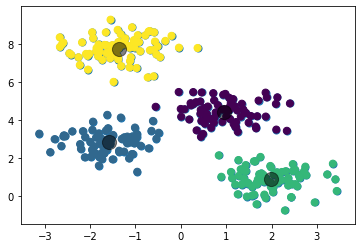

In [11]:
# does everything work as expected?

from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

myCenters, myIdx = ClusterKM(X, 4)

plt.scatter(X[:, 0], X[:, 1], c=myIdx, s=50, cmap='viridis')
plt.scatter(myCenters[:, 0], myCenters[:, 1], c='black', s=200, alpha=0.5);

### 2.3. Image centroids
Apply your k-Means algorithm to the images dataset, using k=20. Make sure to normalize your data first! Show a 20 x 2 grid of images where the first column contains (a) the image that represents the centroid for each of those clusters, and the second column contains (b) the closest image in the original dataset to that centroid. Use Euclidean distance. What do you notice?

*Note:* As you may notice, there are 250*250*3 = 187500 features for each image. If your k-Means algorithm is not implemented efficiently -- an even if it is! -- it might take a long time for your algorithm to converge. If your computer is old, it might even take a very long time for you to simply normalize your data. If you are running into such problems, you may convert your RGB images into greyscale first (using, for instance, the [`rgb2grey`](http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2grey) function).



In [12]:
def normalizeImage(image):
    image = image.astype('float64')
    image = image/255
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = image.reshape(250*250*3)
    return image

In [13]:
normalized_df = df.copy()
normalized_df["Pictures"] = normalized_df["Pictures"].apply(normalizeImage)
X = np.stack(normalized_df["Pictures"].values)

In [14]:
centroids, idx = ClusterKM(X, 20)

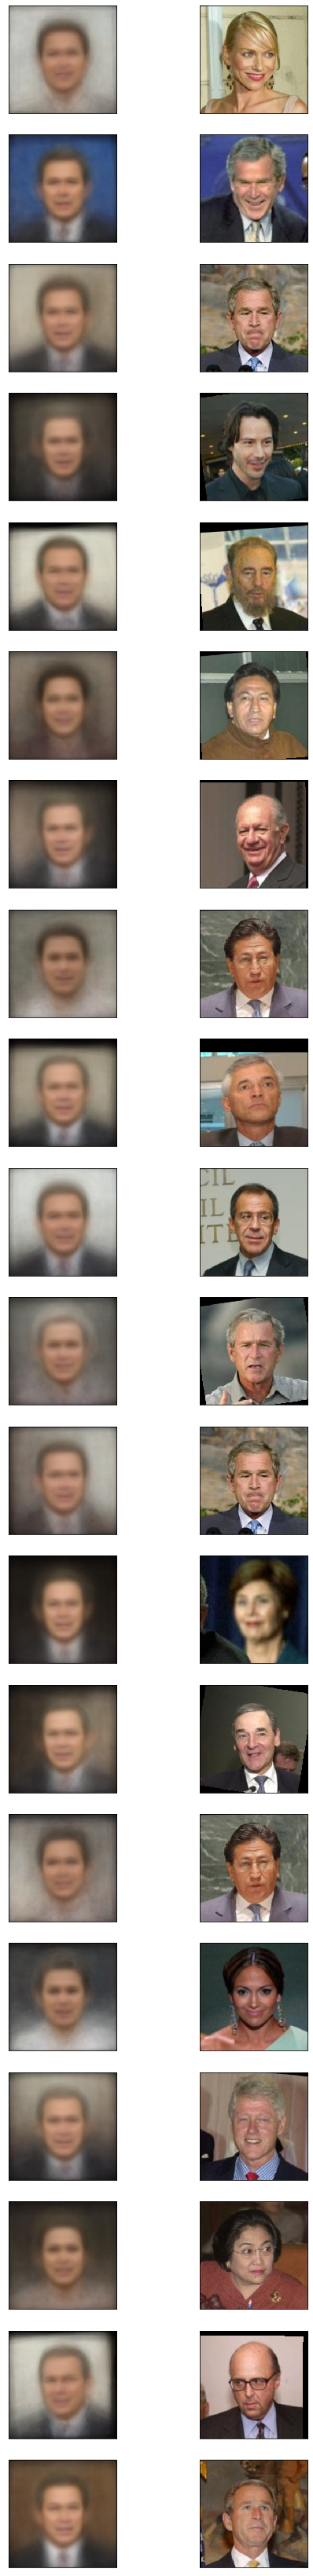

In [15]:
#Finding Closest Neighbours
closest_neighbours = pairwise_distances_argmin(centroids, X, metric='euclidean')

# Plotting
fig, ax = plt.subplots(nrows=20, ncols=2, figsize=(8,60))

for i in range(20):
    ax[i][0].imshow(centroids[i].reshape(250, 250, 3))
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    
    ax[i][1].imshow(X[closest_neighbours[i]].reshape(250,250,3))
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    
plt.show(fig)

In [16]:
np.savetxt('centroids.txt',centroids)
np.savetxt('idx.txt',idx)

In [17]:
centroids = np.loadtxt('centroids.txt')
idx = np.loadtxt('idx.txt')

It is observed that the closest image in the original dataset to a centroid is same /almost similar to image that represents the centroid for that cluster majority of the times.

### 2.4 Classify yourself

Take a picture of yourself and scale it so that it is in a similar format to the images in the dataset. Show four images:
 1. The image of yourself
 2. The cluster centroid closest to that image
 3. The closest image in the original dataset to that cluster centroid
 4. The closest image in the original dataset to the image of yourself


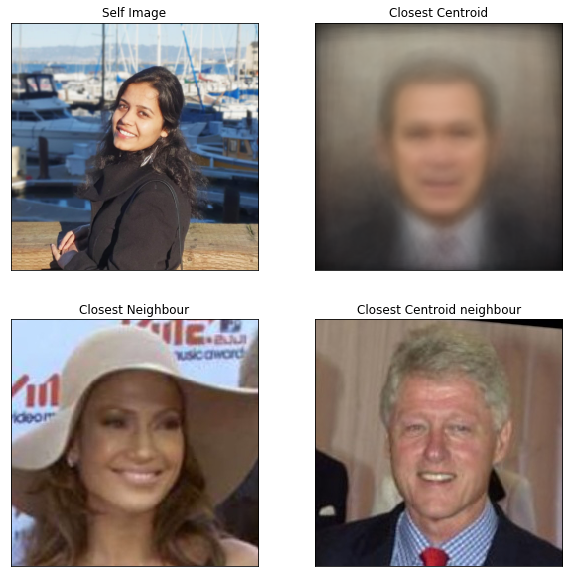

In [19]:
# My Image
from skimage.transform import resize

parul = io.imread('Parul.jpg')
parul = resize(parul,(250,250,3))
parul = parul.reshape((1, 250*250*3))

# Closest Centroid
closest_centroid = pairwise_distances_argmin(parul, centroids, metric='euclidean')

# Closest Image
closest_neighbour = pairwise_distances_argmin(parul, X, metric='euclidean')

# Plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()

ax[0].imshow(parul.reshape(250,250,3))
ax[0].set_title('Self Image')

ax[1].imshow(centroids[closest_centroid[0]].reshape(250,250,3))
ax[1].set_title('Closest Centroid')

ax[2].imshow(X[closest_neighbour[0]].reshape(250,250,3))
ax[2].set_title('Closest Neighbour')

ax[3].imshow(X[closest_neighbours[closest_centroid[0]]].reshape(250,250,3))
ax[3].set_title('Closest Centroid neighbour')

for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show(fig)

## 3. PCA and Eigenfaces 

Begin by normalizing your data. Then, set aside 50% of the images as "test" data and using the remaining images as "training" data.


### 3.1. How many components?

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn on the training dataset. Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 100. How many components are required to explain 75% of the variation in your original data?

In [20]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

train, test= train_test_split(X,train_size = 0.5,random_state=123)
print(train.shape)
print(test.shape)

(2162, 187500)
(2162, 187500)


In [21]:
#Components Required to explain 75% of the variation
pca = PCA(n_components = 0.75)
pca_features = pca.fit_transform(train)
pcs_number= pca_features.shape[1]
print("Number of PCs accounting for 75% of variance: ", pcs_number)

Number of PCs accounting for 75% of variance:  46


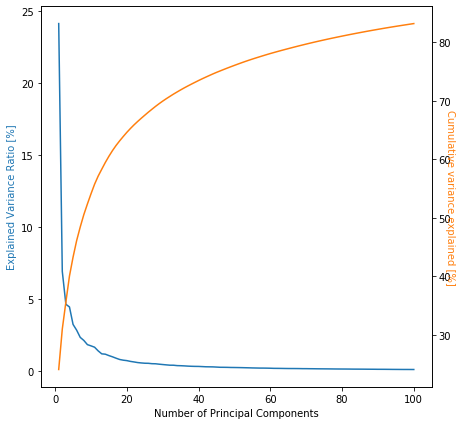

In [22]:
# Fitting PCA Model
pca = PCA(n_components=100)
pca.fit(train)

# Plot
fig, ax = plt.subplots(figsize=(7,7))

ax.plot(np.arange(len(pca.explained_variance_ratio_))+1,
        pca.explained_variance_ratio_*100, color='C0')
ax.set_ylabel('Explained Variance Ratio [%]', color='C0')
ax.set_xlabel('Number of Principal Components')

twinax = ax.twinx()
twinax.plot(np.arange(len(pca.explained_variance_ratio_))+1,
            np.cumsum(pca.explained_variance_ratio_)*100, color='C1')
twinax.set_ylabel('Cumulative variance explained [%]', rotation=270, color='C1')

plt.show(fig);

### 3.2. Eigenfaces

Extract the 10 first principal components (the "eigenfaces") and display them below.

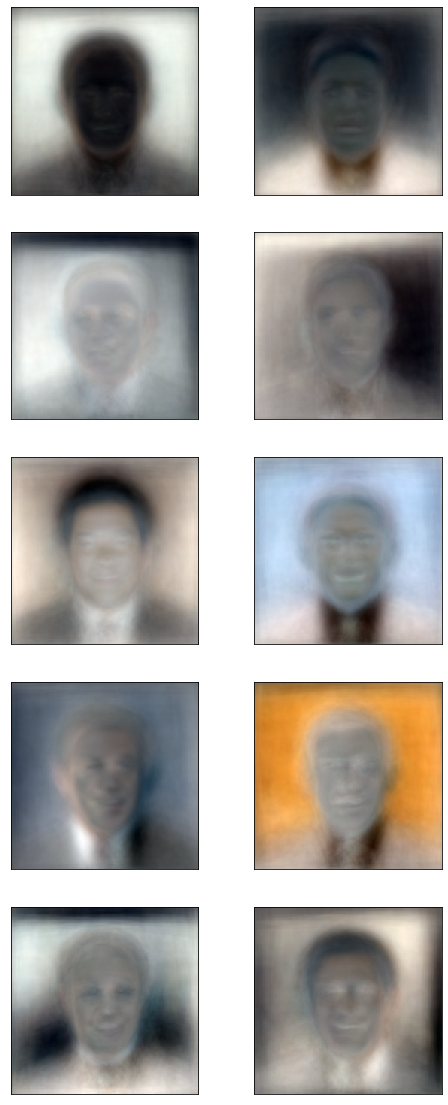

In [22]:
# First 10 components
pc_10 = pca.components_[:10].copy()

for i in range(len(pc_10)):
    pc_10[i] = (pc_10[i] - np.min(pc_10[i])) / (np.max(pc_10[i]) - np.min(pc_10[i]))

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(8,20))
ax = ax.flatten()

for i in range(len(pc_10)):
    ax[i].imshow(pc_10[i].reshape(250,250,3))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show(fig)

### 3.3. Projections, clustering and PCA
 - Project all of the training and test data into the 50-dimensional space defined by the first 50 principal components.
 - Apply k-means clustering, with k=20, to the 50-dimensional projections of the training data. 
 - Display a 4 x 5 grid of images that shows what each of the 20 centroids look like after the centroid is projected back into the original-image space.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


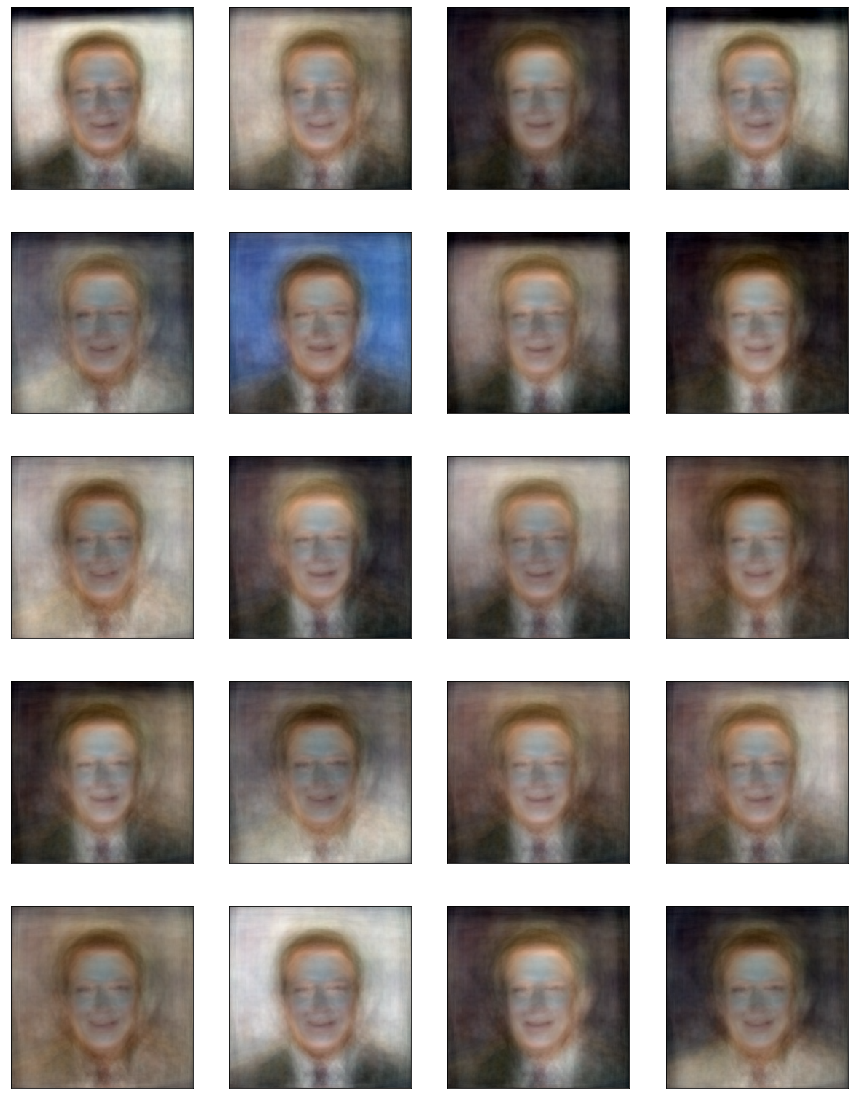

In [23]:
# Projecting into 50-dimensional space
pc_50 = pca.components_[:50].copy()
train_50 = train.dot(pc_50.T)
test_50 = test.dot(pc_50.T)

# Apply K means Cluserting with 20 clusters
centroids_train_50, idx_train_50 = ClusterKM(train_50, 20)
centroids_train_50 = centroids_train_50.dot(pc_50)

# Plotting
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(15,20))
ax = ax.flatten()

for i in range(20):
    ax[i].imshow(centroids_train_50[i].reshape(250, 250, 3))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show(fig);

### 3.4. Recognition

Create a test set of 10 images using (i) 8 images randomly selected from the test data, (ii)  any other non-face image you can find that has the right dimensions, and (iii) an image of yourself. Create a 10 x 5 grid of images, with one row for each of these images, and 5 columns that contain: 
1. The original image. 
2. The reconstruction of that image after it is projected onto the 50-dimensional eigenface-space and then re-projected back into the original image space. 
3. Find the nearest centroid (from 3.3) to the image, and show the reconstruction of that nearest centroid. 
4. Find the image in the training data whose 50-dimensional representation is closest to that centroid, and show the reconstruction of that image.
5. Show the original training image that was selected in above (step 4 in this list)

In [24]:
test_imgs = np.zeros((10, 187500))

# 8 from the test set
test_inds = np.random.choice(np.shape(test)[0], 8, replace=False)
for i in range(len(test_inds)):
    test_imgs[i] = test[test_inds[i]].copy()

# Random Image without face
web_image = io.imread('Web.jpg')
web_image = resize(web_image,(250,250,3))
test_imgs[8]  = web_image.reshape((1, 250*250*3))

# Self
test_imgs[9] = parul

# PCA Projection
test_imgs_50 = test_imgs.dot(pc_50.T)

test_imgs_50 = test_imgs_50.dot(pc_50)

closest_centroids_train_50 = pairwise_distances_argmin(test_imgs_50, centroids_train_50, metric='euclidean')


closest_neighbours_train_50 = pairwise_distances_argmin(centroids_train_50[closest_centroids_train_50],
                                                        train_50.dot(pc_50),
                                                        metric='euclidean')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

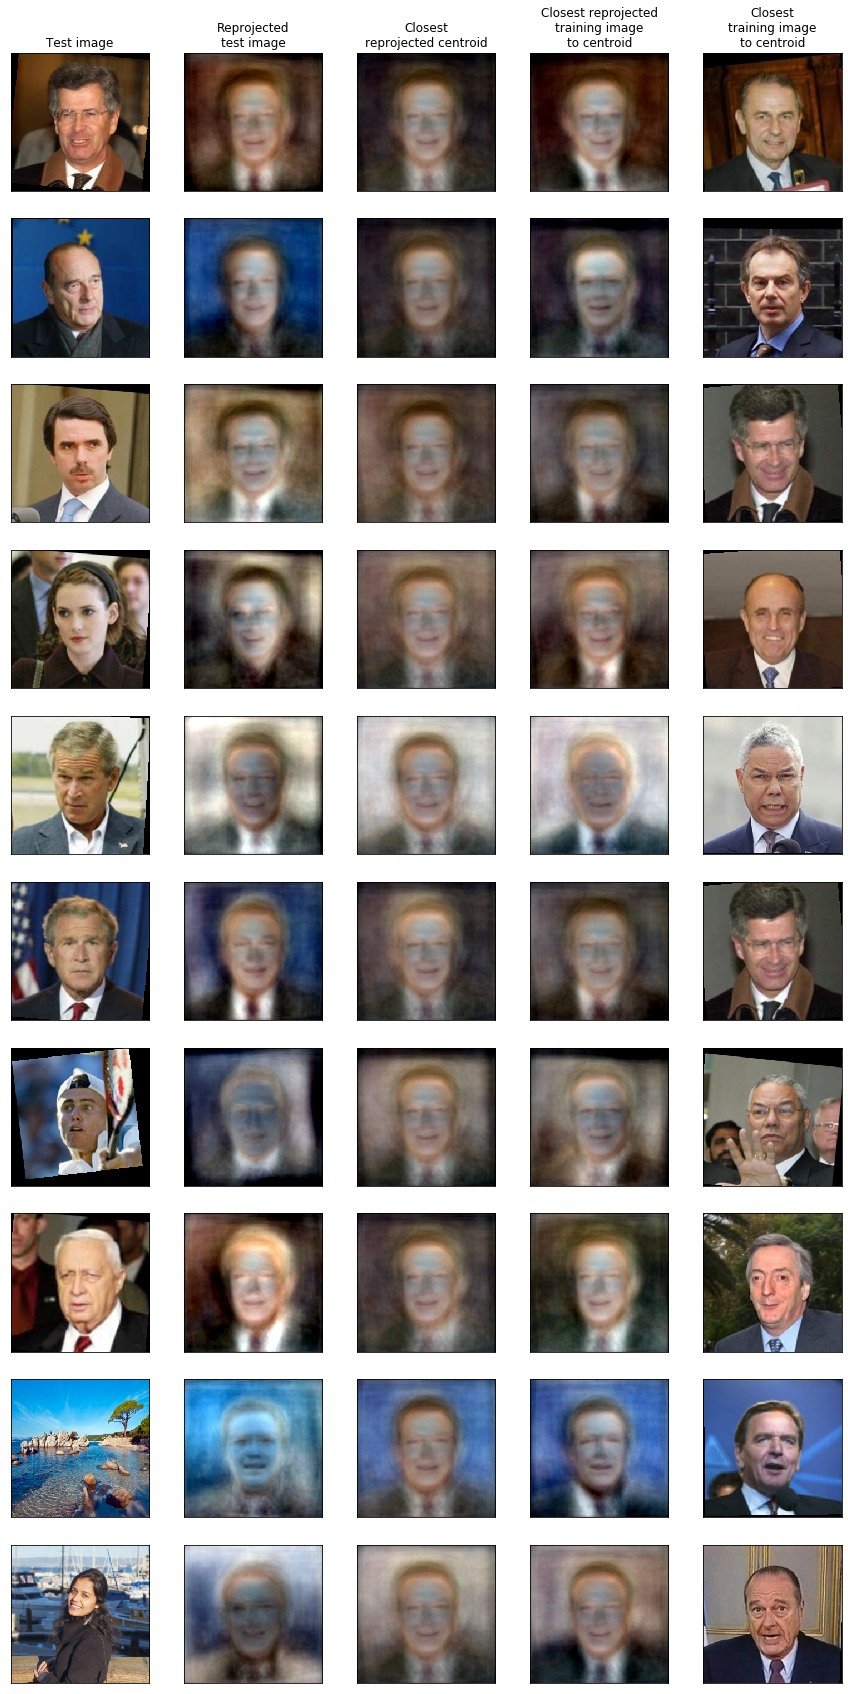

In [26]:
fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(15,30))
for i in range(10):
    
    ax[i][0].imshow(test_imgs[i].reshape(250, 250, 3))
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])

    ax[i][1].imshow(test_imgs_50[i].reshape(250, 250, 3))
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])

    ax[i][2].imshow(centroids_train_50[closest_centroids_train_50[i]].reshape(250, 250, 3))
    ax[i][2].set_xticks([])
    ax[i][2].set_yticks([])

    ax[i][3].imshow(train_50.dot(pc_50)[closest_neighbours_train_50[i]].reshape(250, 250, 3))
    ax[i][3].set_xticks([])
    ax[i][3].set_yticks([])

    ax[i][4].imshow(train[closest_neighbours_train_50[i]].reshape(250, 250, 3))
    ax[i][4].set_xticks([])
    ax[i][4].set_yticks([])

ax[0][0].set_title('Test image')
ax[0][1].set_title('Reprojected\ntest image')
ax[0][2].set_title('Closest\nreprojected centroid')
ax[0][3].set_title('Closest reprojected\ntraining image\nto centroid')
ax[0][4].set_title('Closest\ntraining image\nto centroid')
    
plt.show(fig)

### 3.5. (Extra credit) Share your results
Post the following to bCourses for people in the class to see:
 - The photo of yourself
 - The cluster centroid from 2.4 that is closest to that image
 - The closest image in the dataset to that cluster centroid
 - The reconstruction of your image after it has been projected and reprojected (i.e., #2 in 3.4)
 - The nearest centroid to the projection (i.e., #3 in 3.4)
 - The closest training image to that centroid (i.e., #5 in 3.4)

### 3.6. (Extra extra credit) PCA Implementation

Implement PCA yourself, without using sklearn. How does the running time of your algorithm compare to the running time of the sklearn version?

In [27]:
# Enter your code here

### 3.7. (Extra extra extra credit): k-Means++
- In 2.1 you implemented k-Means clustering with random initialization of the centroids. In this part implement the k-Means++ version of the algorithm that uses a "smarter" initialization of the centroids in order to achieve faster convergence. Compare the number of iterations it took k-Means in 2.3 to converge with random initialization to the number of iterations it takes k-Means++. Also compare the sum of squared errors that you obtain for both methods. Use for both k=20 clusters. The following link shows the paper that proposed k-Means++.
http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf

*Your observations here*